## Purpose
In this example we demonstrate how to:
   - Build a coreset tree on a train data.
   - Adding to the tree additional data through partial build
   - Update samples labels
   - Update samples features
   - Remove samples
   - Compare the model trained on the coreset with the model trained on the full dataset

In this example we'll be using the well-known Covertype Dataset (https://archive.ics.uci.edu/ml/datasets/covertype).
We will split the data to three parts:
  - train_1 - 50% of the data
  - train_2 - 20% of the data
  - test - 30% of the data


In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from dataheroes.services import CoresetTreeServiceLG

In [2]:
# Ignore convergence warnings for logistic regression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Prepare datasets

In [3]:
# Load Covertype dataset as a pandas data frame.
# In the output data frame all columns are features beside the last column.
# The last column (Cover_Type) is the target
df = fetch_covtype(as_frame=True).frame

# Split dataset: train_1 = 50%, train_2=20%, test=30%
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_1, train_2 = train_test_split(train, test_size=20/70, random_state=42)

# Prepare data directory and set the file names.
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
train_1_file_path = data_dir / "train_1.csv"
train_2_file_path = data_dir / "train_2.csv"
test_file_path = data_dir / "test.csv"

# Store datasets as CSV.
# We use the data frame index as the unique identifier and define a column for it (index_column)
# Defining an index column is optional. In this example we set it to have a reference to the original dataset.
train_1.to_csv(train_1_file_path, index_label="index_column")
train_2.to_csv(train_2_file_path, index_label="index_column")
test.to_csv(test_file_path, index_label="index_column")

### 1. Build the tree
Run `build_from_file` on the first train file.
It will include ~290K sample. Let's use `sample_size` of 10K and `coreset_size` of 2K. We supress unnecessary output of last line through `%%capture`. 

In [4]:
%%capture 
# Tell the tree how data is structured.
# In this example we have an index column and a target column.
# All other columns are features.
data_params = {
    'target': {'name': 'Cover_Type'},
    'index': {'name': 'index_column'}
}
# Initialize the service and build the tree.
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
service_obj = CoresetTreeServiceLG(coreset_size=2_000, data_params=data_params)
service_obj.build_from_file(train_1_file_path, sample_size=10_000)

### 2. Plot the tree

PosixPath('output/train_tree.png')

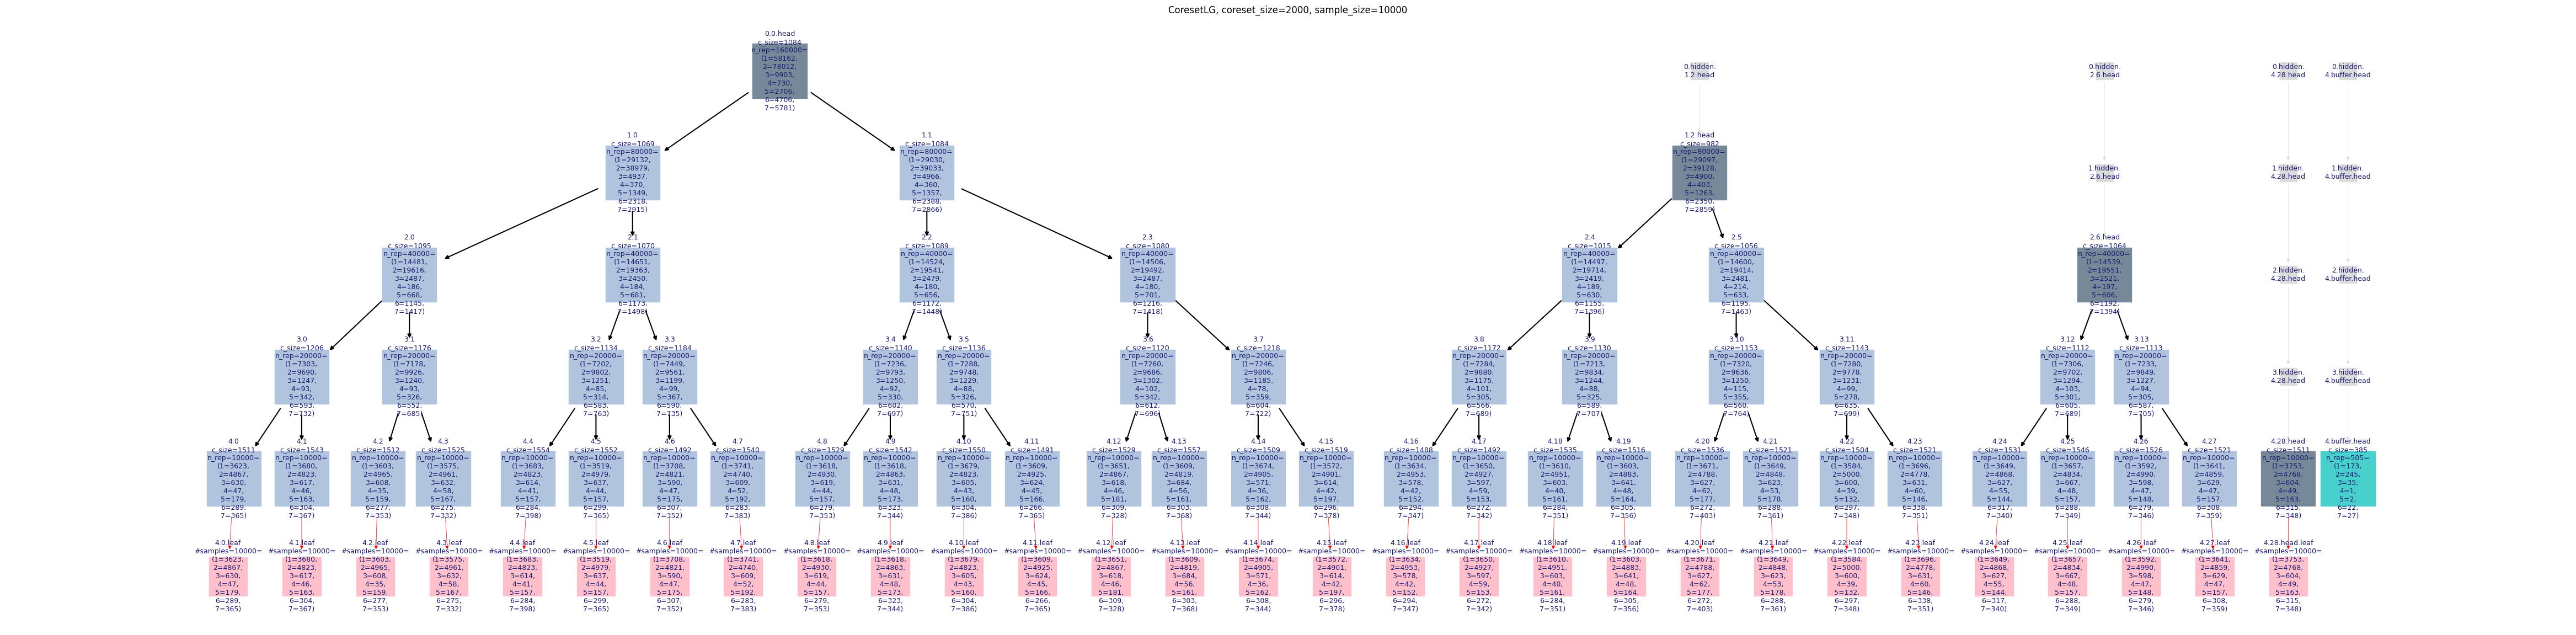

In [5]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir, "train_tree")

### 3. Get coreset from the tree, train a model based on it

In [6]:
# Get the top level coreset (~2K samples with weights)
coreset = service_obj.get_coreset()
indices, X, y = coreset['data']
w = coreset['w']
# Train a logistic regression model on the coreset.
coreset_model = LogisticRegression().fit(X, y, sample_weight=w)
n_samples_coreset = len(y)

### 4.1. Train a model on the full dataset for comparison
We use the same part of the dataset that was used for building the tree

In [7]:
X = train_1.iloc[:, :-1].to_numpy() 
y = train_1.iloc[:, -1].to_numpy()

full_dataset_model = LogisticRegression().fit(X, y)
n_samples_full = len(y)

### 4.2. Compare models quality
Test both coreset and full model on test dataset and compare theirs AUC scores

In [8]:
# Read test dataset from file
test_df = pd.read_csv(test_file_path)
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy()

# Evaluate model
coreset_score = roc_auc_score(y_test, coreset_model.predict_proba(X_test), multi_class='ovr')
full_dataset_score = roc_auc_score(y_test, full_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Coreset AUC score ({n_samples_coreset:,} samples): {coreset_score}")
print(f"Full dataset AUC score ({n_samples_full:,} samples): {full_dataset_score}")

Coreset AUC score (864 samples): 0.8304016252220434
Full dataset AUC score (290,505 samples): 0.7903846802843272


### 5.1. Save the tree for later use

In [9]:
%%capture
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_1_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

### 5.2. Load the saved tree

In [10]:
service_obj = CoresetTreeServiceLG.load(out_dir, save_tree_name)

### 6. Partial build
Add the second train dataset to the tree using `partial_build_from_file`.

In [11]:
%%capture
service_obj.partial_build_from_file(train_2_file_path)

### 7. Get important samples
Call `get_important_samples` for a certain (biggest) class for 100 samples to identify mislabeled samples.

In [12]:
# There are 7 classes, we choose the biggest one, that is 2
biggest_class = 2
number_important_samples = 100
important_samples = service_obj.get_important_samples(class_size={biggest_class: number_important_samples})

### 8. Update targets
Call `update_targets` for some returned samples above. For further compare models result (tree vs. full dataset) we also do update targets same way, for same samples on full dataset.

In [13]:
# take first 10 samples for update (0..9)
indexes_for_update_targets = np.arange(0,10)
# updating target with different values (not equal 2)
y_new = [1, 3, 3, 3, 3, 4, 5, 6, 7, 7]
# update selected samples on the coreset tree
service_obj.update_targets(important_samples['idx'][indexes_for_update_targets], y_new)

# Same update on full dataset
train.loc[important_samples['idx'][indexes_for_update_targets], 'Cover_Type'] = y_new

### 9. Update features
Call `update_features` for some returned samples above (different ones than 8).

In [14]:
# take next 10 samples for update (10..19)
indexes_for_update_features = np.arange(10,20)
X_new = important_samples['X'][indexes_for_update_features]
# modify X, as simple example - set all binary fields = 1
for sample in X_new:
    sample[sample == 0] = 1
# update selected samples on the coreset tree
service_obj.update_features(important_samples['idx'][indexes_for_update_features], X_new)

# same features update on full dataset
train.loc[important_samples['idx'][indexes_for_update_features], train.columns[:-1]] = X_new

### 10. Remove samples
Call `remove_samples` for some returned samples above (different ones than 8 and 9).

In [15]:
# take next 10 samples for remove (20..29)
indexes_for_remove = np.arange(20,30)
# remove selected samples on the coreset tree
service_obj.remove_samples(important_samples['idx'][indexes_for_remove])

# remove same samples on full dataset
train = train.drop(train.loc[important_samples['idx'][indexes_for_remove]].index)

### 11. Filter data on the tree
Run `filter_out` to filter out all samples with elevation < 2000.

In [16]:
# index of Elevation feature
elevation_feature_index = list(df.columns).index('Elevation')
# filter function
def filter_out_elevation_less_2000(indexes, X, y):
    return indexes[X[:, elevation_feature_index] < 2000]
# filter samples on the tree
service_obj.filter_out_samples(filter_out_elevation_less_2000)

# Same filter on full dataset
train = train[train['Elevation'] >= 2000]

### 12. Fit on the tree
Run `fit` directly on the tree

In [17]:
service_obj.fit()
n_samples_coreset = len(service_obj.get_coreset()['w'])

### 13. Save coreset

In [18]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.save_coreset(final_coreset_path)

### 14.1 Train model of entire dataset
Train model of entire train dataset to compare AUC score with coreset

In [19]:
X = train.iloc[:, :-1].to_numpy()
y = train.iloc[:, -1].to_numpy()

full_updated_dataset_model = LogisticRegression().fit(X, y)
n_samples_full = len(y)

 ### 14.2 Compare models quality

In [20]:
final_tree_lg_score = roc_auc_score(y_test, service_obj.predict_proba(X_test), multi_class='ovr')
full_updated_dataset_score = roc_auc_score(y_test, full_updated_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Updated Coreset AUC score ({n_samples_coreset:,} samples): {final_tree_lg_score}")
print(f"Full updated dataset AUC score ({n_samples_full:,} samples): {full_updated_dataset_score}")

Updated Coreset AUC score (954 samples): 0.815547588825244
Full updated dataset AUC score (405,808 samples): 0.8023956575514263
